In [1]:
# set up

from __future__ import print_function, division

%matplotlib inline

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

## Analytic methods

if we know parameters of sampling distribution, CI and p-values calculate analytically (since faster)

In [5]:
import scipy.stats

def EvalNormalCdfInverse(p, mu=0, sigma=1):
    return scipy.stats.norm.ppf(p, loc=mu, scale=sigma)

# CI for estimated mean (90 kg gorilla weight)

CiLow = EvalNormalCdfInverse(0.05, mu=90, sigma=2.5)

CiHigh = EvalNormalCdfInverse(0.95, mu=90, sigma=2.5)
print(CiLow, CiHigh)

85.88786593262132 94.11213406737868


# 14.2 Normal Distribution

'closed' in linear transformation and in addition

x ~ N(mu, sigma**2)

In [6]:
from normal import Normal

#distribution with mean 90kg and variance  7.5kg
dist = Normal(90, 7.5**2)
dist


Normal(90, 56.25)

In [7]:
dist_xbar = dist.Sum(9) /9
dist_xbar.sigma

2.5

In [8]:
# Confidence Interval 

dist_xbar.Percentile(5), dist_xbar.Percentile(95)

(85.88786593262132, 94.11213406737868)

## Central Limit Theorem

add up indep. vairates from a distribution (same) with finite mean and variance, the sum converges on a normal distribution


### 14.5 Testing the CLT

In [15]:
def MakeExpoSamples(beta=2.0, iters=1000):
    """Generates samples from an exponential distribution.

    beta: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.exponential(beta, n))
                 for _ in range(iters)]
        samples.append((n, sample))
    return samples


In [17]:

#This function generates normal probability
#plots for samples with various sizes.

def NormalPlotSamples(samples, plot=1, ylabel=''):
    """Makes normal probability plots for samples.

    samples: list of samples
    label: string
    """
    for n, sample in samples:
        thinkplot.SubPlot(plot)
        thinkstats2.NormalProbabilityPlot(sample)

        thinkplot.Config(title='n=%d' % n,
                         legend=False,
                         xticks=[],
                         yticks=[],
                         xlabel='random normal variate',
                         ylabel=ylabel)
        plot += 1

C:\Users\ansve\Coding\Think Stats 2\code\thinkplot.py:182: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  return plt.subplot(rows, cols, plot_number, **options)


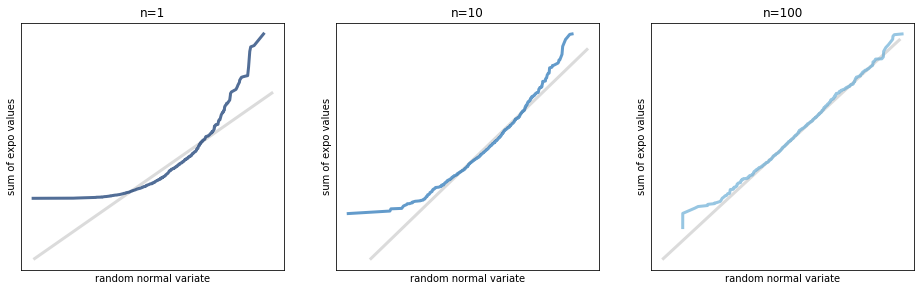

In [18]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeExpoSamples()
NormalPlotSamples(samples, plot=1,
                  ylabel='sum of expo values')

In [21]:
### lognormal distr. higher variance -> requires larger sample

def MakeLognormalSamples(mu=1.0, sigma=1.0, iters=1000):
    """Generates samples from a lognormal distribution.

    mu: parmeter
    sigma: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = []
    
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.lognormal(mu, sigma, n)) 
                 for _ in range(1000)]
        samples.append((n, sample))
    return samples

C:\Users\ansve\Coding\Think Stats 2\code\thinkplot.py:182: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  return plt.subplot(rows, cols, plot_number, **options)


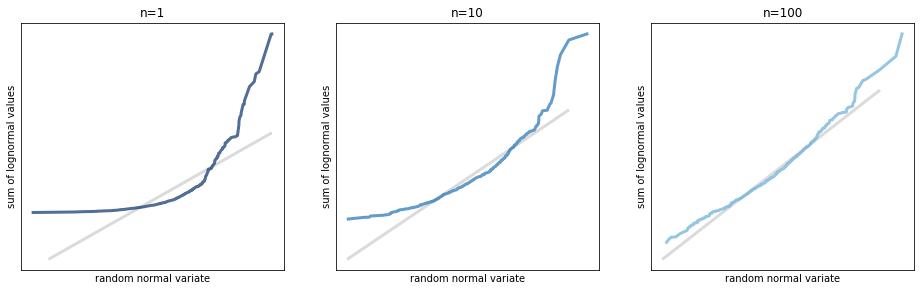

In [22]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeLognormalSamples()
NormalPlotSamples(samples, ylabel='sum of lognormal values')

## Pareto Distr.

not possible since no finite mean / variance - doesn't converge to normal

## Correlated Expo. Distribution

even though against the CLT assumptions, in practice only slight problem without relevance

### 14.6 Applying the CLT

### Difference in Means

pregnancy length not normal 

but mean ( or sum ) of a few thousand samples is very close to normal

In [24]:
import first

live, firsts, others = first.MakeFrames()
delta = firsts.prglngth.mean() - others.prglngth.mean()
# difference in mean length of pregnancy
delta

0.07803726677754952

In [27]:
def SamplingDistMean(data, n):
    """Computes the sampling distribution of the mean.

    data: sequence of values representing the population
    n: sample size

    returns: Normal object
    """
    mean, var = data.mean(), data.var()
    dist = Normal(mean, var)
    return dist.Sum(n) / n

In [30]:
dist1 = SamplingDistMean(live.prglngth, len(firsts))
dist2 = SamplingDistMean(live.prglngth, len(others))

dist_diff = dist1 - dist2
dist

Normal(90, 56.25)

### 14. 7 Correlation

test mothers age and baby weight (used permutation / resampling in previous chapter)

under Null-Hyptothesis Student-t distribution

In [32]:
def StudentCdf(n):
    """Computes the CDF correlations from uncorrelated variables.

    n: sample size

    returns: Cdf
    """
    ts = np.linspace(-3, 3, 101)
    ps = scipy.stats.t.cdf(ts, df=n-2)
    rs = ts / np.sqrt(n - 2 + ts**2)
    return thinkstats2.Cdf(rs, ps)

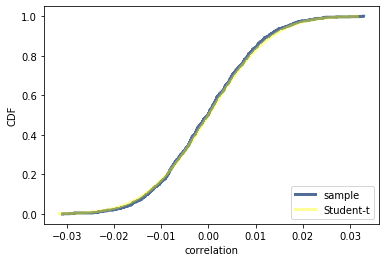

In [37]:
# Hypothesis Test with permutation to estimate sampl. distr of correlation
import hypothesis

class CorrelationPermute(hypothesis.CorrelationPermute):
    """Tests correlations by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: tuple of xs and ys
        """
        xs, ys = data
        return np.corrcoef(xs, ys)[0][1]
    
# est. sampling distribution of correlation by permutation
# and compare it to Student-t distribution

def ResampleCorrelations(live):
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p_value = ht.PValue()
    return len(live2), ht.actual, ht.test_cdf


# plot the 1)cdf of ResampleCorrelation and 2) Student-t Distr

# 1)
n, r, cdf = ResampleCorrelations(live)
thinkplot.Cdf(cdf, label='sample')

# 2) Student-t
model = StudentCdf(n)
thinkplot.Plot(model.xs, model.ps, color='yellow', alpha=0.4, label='Student-t')

thinkplot.Config(xlabel='correlation', ylabel='CDF', legend=True, loc='lower right')

In [38]:
# conforms the analytic results

# calculate Correlation and p_value of correlation 
# with analytic method

t = r * np.sqrt((n-2) / (1-r**2))
p_value = 1 - scipy.stats.t.cdf(t, df=n-2)
print(r, p_value)

0.06883397035410903 2.861466619208386e-11


### Ch. 14.8 Chi-squared Test

__recap__
- chi-squared sum((Oi-Ei)**2 / Ei)
- normalisiert. Keine Vorzeichen und grosse Werte haben mehr gewicht.


In [44]:
def ChiSquaredCdf(n):
    """Discrete approximation of the chi-squared CDF with df=n-1.

    n: sample size
    df: degree of freedom (sometimes hard to get)
    
    returns: Cdf
    """
    xs = np.linspace(0, 25, 101)
    ps = scipy.stats.chi2.cdf(xs, df=n-1)
    return thinkstats2.Cdf(xs, ps)

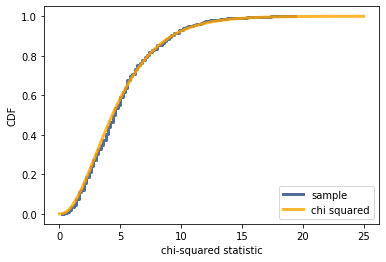

In [47]:
# confirm analytic test with results from simulation

# 1) crooked dice test (from previous chapter)
data = [8, 9, 19, 5, 8, 11] # number of times 1, 2, 3, etc comes up
dt = hypothesis.DiceChiTest(data)
p_value = dt.PValue(iters=1000)
n, chi2, cdf = len(data), dt.actual, dt.test_cdf

thinkplot.Cdf(cdf, label='sample')

# 2) analytic model
model = ChiSquaredCdf(n)
thinkplot.Plot(model.xs, model.ps, 
               label = 'chi squared', alpha=0.8, 
               color='orange')


thinkplot.Config(xlabel='chi-squared statistic',
                 ylabel='CDF',
                 loc='lower right')